# try another method load model data

In [1]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import utils as ut
import lom


%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater

# Region

Text(0.5, 0.98, 'colours assigned')

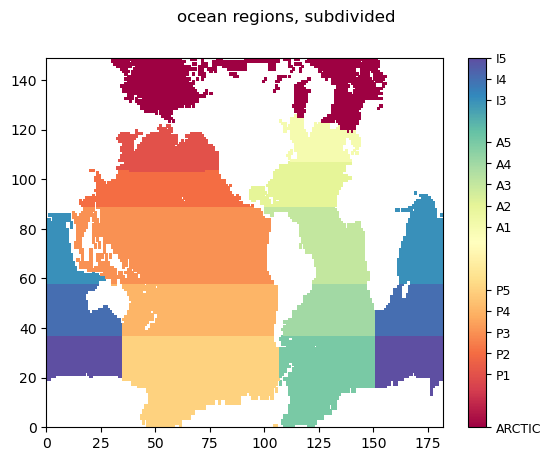

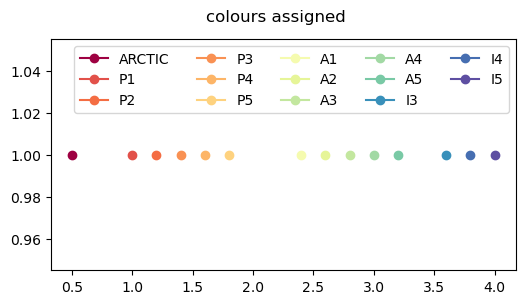

In [8]:
regs = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'ARCTIC' : {'number' : 0.5},
           'P1' : {'number': 1.0},
          'P2' : {'number': 1.2},
           'P3' : {'number': 1.4},
           'P4' : {'number': 1.6},
           'P5' : {'number': 1.8},
            'A1' : {'number': 2.4},
          'A2' : {'number': 2.6},
           'A3' : {'number': 2.8},
           'A4' : {'number': 3},
           'A5' : {'number': 3.2},
           'I3' : {'number': 3.6},
           'I4' : {'number': 3.8},
           'I5' : {'number': 4},
           
          }
    
tics = []
tcm = 'Spectral'
tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
    tics.append(regdict[regs[i]]['number'])
maskno[maskno == 0] = np.nan

w = plt.pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
cbar = plt.colorbar(w, ticks=tics)
t = cbar.ax.set_yticklabels(['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5'], fontsize = 9)
plt.suptitle('ocean regions, subdivided')

fact = 0.2
fig = plt.figure(figsize=(30*fact,15*fact))
import matplotlib
cmap = matplotlib.cm.get_cmap('Spectral')
norm = matplotlib.colors.Normalize(vmin=0.5, vmax=4)
for i in range(0,len(regs)):
    rgba = cmap(norm(regdict[regs[i]]['number']))
    plt.plot(regdict[regs[i]]['number'], 1, marker = 'o', color = rgba, label = regs[i])
    regdict[regs[i]]['colour'] = rgba
plt.legend(ncol = 5, fontsize = 10)
plt.suptitle('colours assigned')

# Read data

    - tmesh, csize_broad,

In [3]:
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:] # area of grid cells
csize_broad = np.zeros([31,149,182])
for i in range(0,31):
    csize_broad[i,:,:] = tmesh['csize'].values
cvol = csize_broad * tmesh['e3t_0'][0,:,:,:] * tmesh['tmask'][0,:,:,:]


# ??maskno_broad

In [ ]:

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
    tics.append(regdict[regs[i]]['number'])
maskno[maskno == 0] = np.nan

# depths = (tmesh['gdept_1d'][0])

    - res_g

In [9]:
regs_g = regs.copy()
regs_g.append('GLOBAL')
print(regs_g)

['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5', 'GLOBAL']


    - Extract model data

In [ ]:
extracthorse = False
if extracthorse:
    yst = 1955; yen = 1960; 
    modlist = [ 'TOM12_DW_WE43', 'TOM12_DW_GA01']


    for modnam in modlist:
        dtype = 'grid_T'; #modnam = modlist[r]
        fnam = f'./EXTRACTED/MLD/MLD_{modnam}_{yst}_{yen}.nc'
        print(fnam)

        ylist = ut.make_yearlist(yst, yen, dtype, modnam)
        tdat = xr.open_mfdataset(ylist)

        mldkz5 = np.zeros([15,12])
        mldkz5_m = tdat.mldkz5.groupby('time_counter.month').mean('time_counter').values
        for r in range(0,len(regs)):
            csize_copy = np.copy(csize_broad)
            csize_copy[maskno_broad != regdict[regs[r]]['number']] = 0
            for i in range(0,12):
                mldkz5[r,i] = np.ma.average(mldkz5_m[i,:,:], weights = csize_copy[0,:,:])
        ### get the global one
        for i in range(0,12):
            mldkz5[14,i] = np.ma.average(mldkz5_m[i,:,:], weights = csize_broad[0,:,:])

        mldr10_1 = np.zeros([15,12])
        mldr10_1_m = tdat.mldr10_1.groupby('time_counter.month').mean('time_counter').values
        for r in range(0,len(regs)):
            csize_copy = np.copy(csize_broad)
            csize_copy[maskno_broad != regdict[regs[r]]['number']] = 0
            for i in range(0,12):
                mldr10_1[r,i] = np.ma.average(mldr10_1_m[i,:,:], weights = csize_copy[0,:,:])
        ### get the global one
        for i in range(0,12):
            mldr10_1[14,i] = np.ma.average(mldr10_1_m[i,:,:], weights = csize_broad[0,:,:])        

        data_vars = {'mldkz5':(['region', 'month'], mldkz5,
                                 {'units': 'm'}),
                    'mldr10_1':(['region', 'month'], mldr10_1,
                                 {'units': 'm'}),             
                    }

        coords = {'region': (['region'], regs_g),\
                 'month': (['month'], np.arange(1,13,1))}

        # define global attributes
        attrs = {'made in':'AnalysisRobot/Tester_multimodel_MLD.ipynb',
                }

        # create dataset
        ds = xr.Dataset(data_vars=data_vars,
                        coords=coords,
                        attrs=attrs)
        ds.to_netcdf(fnam)